Importing Packages And Basic Set up

In [1]:
#.venv/scripts/activate  ; no source. 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.preprocessing import StandardScaler  
from plotnine import *

import numpy as np
import pandas as pd

np.random.seed(42)

Importing Datasets

In [2]:
# Importing maindata

file_path = "C://Users//soren/Downloads/"

x = pd.read_stata(file_path + "maindata.dta", convert_categoricals=False)

# Importing laws_csv, cleaning it
laws_csv = pd.read_csv("When_Were_Laws.csv")
laws_csv = laws_csv[np.logical_not(np.isnan(laws_csv["FIPS"]))]  # FIPS codes identify states
laws_csv = laws_csv.drop("State_Name", axis=1)  # Dropping as useless
laws_csv = laws_csv.rename({'FIPS': 'stfips'}, axis=1) 

# Merging
merged = pd.merge(laws_csv, x, on='stfips', how='outer')

Cleaning Datasets, only interested in the 1997 states. 

In [3]:
basic_merged = merged.copy()  # To allow for re-running 

basic_merged = basic_merged[basic_merged["a_age"] <= 25]  # Can be changed later, but for now useful I think

# Dropping states who were treated < 97 (i.e. they always had programs)
# This is following Callaway + Sant'anna, as we cannot meaningfully 
# do any inference using those states. Although we can compare them later as a 
# robustness check, which may be interesting
basic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("always")==False]  

# Making it so that "never-treated" states are treated at T = infinity
basic_merged = basic_merged.replace("never", "1000000") 
basic_merged["Year_Implemented"] = basic_merged["Year_Implemented"].astype(int)  # converting to int

# Indicator for if the individual was treated (i.e. under 19 and in a state who added a law)
basic_merged["treatment"] = basic_merged["under19"] # * basic_merged["year_indic"]

# Generating list of confounders of interest, these are not necessarily optimal. 
list_of_confounders = ["year", "stfips", "fownu18", "faminctm1", "a_maritl", "female" , "fpovcut", "povll"]
list_of_confounders += ["anykids", "disability", "noemp_insured"]

$\underline{\bold{\text{Estimating causal effect}}}$

Subsetting data

Fitting Model

In [4]:
def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, year_of_interest:int):
    '''
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each set of covariates in fold j
    3b. Each set of covariates is fitted for each combination of year x treatment
    4. We return a matrix which contains those predictions as columns (each column is one combinatino of year x treatment)
    5. We also return vectors which indicate the true year/treatment status for that particular set of covariates
    

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    year_of_interest: year that treatment occured
    '''
    # Setting up prediction vectors
    # the 2*i'th column is year `i` with treatment = 0
    # the (2*i)+1'th column is year `i` with treatment = 1
    # As we predict for 18 years, there are 36 columns. 
    predictions_matrix = np.empty(shape=(y.shape[0], 36))

    # k-folding
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # Generating vectors which will contain the true treatment/year combination for each covariate. 
    year_vec = np.full_like(X_w_treatment["year"], np.nan, dtype=float)
    treat_vec = np.full_like(X_w_treatment["year"], np.nan, dtype=float)

    # Normalizing years so that year =1 when treatment first occurs. 
    X_w_treatment["year"] = X_w_treatment["year"] - (year_of_interest - 1)

    for train_index, test_index in kf.split(X_w_treatment, y):
        X_train = X_w_treatment.loc[train_index]
        y_train = y.loc[train_index]
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        q = make_model()
        q.fit(X_train, y_train)

        # This saves the vector of years so we only get the att for the 1997 group
        year_vec[test_index] =  X_w_treatment["year"].loc[test_index]

        # This saves the vector of treated statuses, as we want to condition on A = 1 (we want ATT, not ATE)
        treat_vec[test_index] = A.loc[test_index]

        for j in range(1991, 2009):
            X0 = X_w_treatment.copy()
            X0["A"] = 0  # Setting treatment to 0 
            X0["year"] = j - (year_of_interest-1)  # Normalizing year
            X0 = scaler.transform(X0)
            col_num = 2*(j - 1991)  # Which column the data should go in
            predictions_matrix[test_index,col_num] = q.predict_proba(X0[test_index,:])[:, 1]
        for j in range(1991,2009):
            X1 = X_w_treatment.copy()
            X1["A"] = 1  # Setting treatment to 1
            X1["year"] = j - (year_of_interest-1)  # Normalizing year
            X1 = scaler.transform(X1)
            col_num = 2*(j - 1991) + 1  # Which column the data should go in
            predictions_matrix[test_index,col_num] = q.predict_proba(X1[test_index,:])[:, 1]

    assert np.isnan(predictions_matrix).sum() == 0  # Sanity check that we have no missings
    return predictions_matrix, year_vec, treat_vec

Define Q models to Use

In [5]:
# Works the best
def make_Q_model():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5)

def mlp():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return MLPClassifier(solver='adam', hidden_layer_sizes=(15,), random_state=1, max_iter=500)

def xgb():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return XGBClassifier()

# Works okay
def extra_trees():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return ExtraTreesClassifier(random_state=42)

Estimating the ATT's


In [6]:
def ATT_event_study(stfips:np.ndarray, year_of_interest:int, response:str, confounder_list:list, dataframe:pd.DataFrame, model):
    '''
    Estimates ATT(g,t) for the combinations of g,t which we are interested in. 

    Based on Callaway & Sant'anna, we compute ATT(g,t) over time

    We say that ATT(g,t) is the ATT for group g at time `t`
    We compare the outcomes at time `t` to a base date, which we refer to as g_d_1
    
    If time `t` occurs >= treatment_year (i.e. when treatment first occurs), then g_d_1 = treatment_year - 1
    Otherwise, we say that g_d_1 = t - 1

    For intuition, if t >= treatment_year, we are looking at the DiD comparing outcomes at time `t` to 
    those which were immediately before treatment. If t < treatment_year, then we are performing a robustness check.
    That robustness check involves pretending that treatment occured at time t, and comparing it to the previous period's outcomes. 

    For each g,t of interest, we compute:

    ATT(g,t) = E(G_g/E(G_g) * (m_treat_1(X) - m_treat_0(X) - (m_nev_1(X) - m_nev_0(X))))

    m_treat_i(X) = prediction for the outcome for an individual with covariates `X` in year `t` who recieved treatment = `i`
    m_nev_i(X)   = prediction for the outcome for an individual with covariates `X` in year `g_d_1` who recieved treatment = `i`

    We also compute standard errors, and return the ATT(g,t) + standard errors as two different lists. 

    stfips: the FIPS codes for the states of interest
    year_of_interest: the year at which treatment first occurs
    response: which outcome we are interested in, out of public/private/all insurance. 
    confounder_list: list of columns of dataframe to use as confounders
    dataframe: dataframe to get data from
    model: machine learning ensemble model to use as the Q model
    '''

    results_df = {}
    state_level = dataframe.loc[dataframe['stfips'].isin(stfips), :] # Subset for states of interest

    # outcome in  ["pubonly", "insured", "privonly"]
    state_level = state_level[confounder_list+ ["treatment", response]]  # Subsetting for features of interest

    # Drop missings
    state_level = state_level.dropna(axis = 0)

    # Setting up 
    state_level = state_level.reset_index(drop=True)
    confounders = state_level[list_of_confounders]
    treatment = state_level['treatment']
    outcome = state_level[response]

    # Fitting
    predictions_matrix, year_vec, treat_vec = outcome_k_fold_fit_and_predict(model, \
                                        X=confounders, y=outcome, A=treatment,  n_splits=5, \
                                        year_of_interest=year_of_interest) 
    # the 2*i'th column is always the untreated vec, and the (2*i)+1 is treated. 

    weight = (year_vec == 1) * (treat_vec == 1) # We only want the ATT, so we weight appropriately
                                                # to only look at the untils treated at t=1
    weight = weight / np.mean(weight) # To ensure mean of the weights is 1, weights are >= 0 by construction
    
    for i in range(1,18): # we look at the ATT for 1992-2008 (cannot look at 1991 as we have no 1990 data)
        year = i + 1991 # What actual year we are looking at in the for loop
        term_1 = predictions_matrix[:,(2*i)+1]  # m_treat_1 
        term_3 = predictions_matrix[:,(2*i)]    # m_nev_1

        if year >= year_of_interest: # If we've gotten to the treatment year 
            term_2 = predictions_matrix[:,(2*(year_of_interest-1991))-1]  # m_treat_0
            term_4 = predictions_matrix[:,(2*(year_of_interest-1991))-2]  # m_nev_0
        else:  # otherwise we do a short difference. 
            term_2 = predictions_matrix[:,(2*i)-1]  # m_treat_0
            term_4 = predictions_matrix[:,(2*i)-2]  # m_nev_0
        final = weight * (term_1 - term_2 - (term_3 - term_4))  
        # Multiplying by 100 to convert to %
        mean = np.mean(final) * 100
        ste = np.std(final) * 100 / np.sqrt(term_1.shape[0])

        results_df.setdefault('year',[]).append(i + 1991)
        results_df.setdefault('att',[]).append(mean)
        results_df.setdefault('std',[]).append(ste)
        results_df.setdefault('model',[]).append(model.__name__ )
        results_df.setdefault('response',[]).append(response)
        results_df.setdefault('treat_year',[]).append(year_of_interest)

    results_df = pd.DataFrame(results_df)

    return results_df

In [7]:
# Simple test to make sure the above functions work

# Get all states which implemented programs in that year
states_in_year = basic_merged[basic_merged['Year_Implemented'] == 1997]["stfips"].unique()
test_df = ATT_event_study(states_in_year, 1997, "pubonly",list_of_confounders,basic_merged, make_Q_model)

test_df.head()

,year,att,std,model,response,treat_year
0,1992,0.330245,0.021052,make_Q_model,pubonly,1997
1,1993,0.337003,0.021866,make_Q_model,pubonly,1997
2,1994,0.349995,0.022945,make_Q_model,pubonly,1997
3,1995,0.360248,0.023906,make_Q_model,pubonly,1997
4,1996,0.360882,0.024252,make_Q_model,pubonly,1997


In [7]:
# Evaluate the ATT's for all the states which implemented programs after 1997

# Get all years (other than never) and 2001 that states implemented programs
law_years = np.sort(basic_merged['Year_Implemented'].unique())[:-2]

all_years = pd.DataFrame()

for year in law_years:

    # Get all states which implemented programs in that year
    states_in_year = basic_merged[basic_merged['Year_Implemented'] == year]["stfips"].unique()

    new_year = ATT_event_study(states_in_year, year, "pubonly",list_of_confounders,basic_merged, make_Q_model)
        
    all_years = pd.concat([all_years, new_year], ignore_index=True)

all_years.head()

# Evaluate the ATT's for all the states which never implemented programs

# Get all years (other than never) that states implemented programs
year = np.sort(basic_merged['Year_Implemented'].unique())[-1]

# Get all states which implemented programs in that year
states_in_year = basic_merged[basic_merged['Year_Implemented'] == year]["stfips"].unique()

# Pretend that state implemented programs in 2006 (since )
new_year = ATT_event_study(states_in_year, 2008, "pubonly",list_of_confounders,basic_merged, make_Q_model)
    
all_years = pd.concat([all_years, new_year], ignore_index=True)
all_years['adjusted_year'] = all_years["year"] - all_years["treat_year"]

all_years.head()

,year,att,std,model,response,treat_year,adjusted_year
0,1992,0.001813,0.000919,make_Q_model,pubonly,1997,-5
1,1993,-0.003021,0.000888,make_Q_model,pubonly,1997,-4
2,1994,0.004817,0.001555,make_Q_model,pubonly,1997,-3
3,1995,0.003528,0.000910,make_Q_model,pubonly,1997,-2
4,1996,0.001580,0.000833,make_Q_model,pubonly,1997,-1


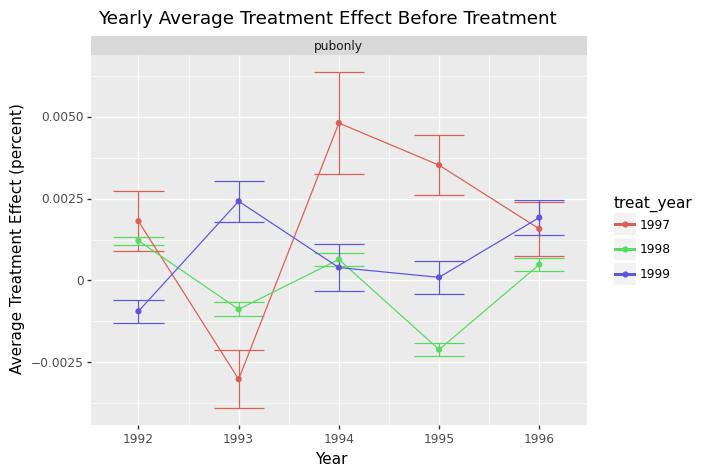

<ggplot: (135587784482)>

In [50]:
# Plotnine code to make plot for pre-treatment effects
pre_treat = all_years[(all_years["year"] < 1997) & (all_years["treat_year"] != 2008)].copy()

pre_treat["treat_year"] = pre_treat["treat_year"].replace(2008, "Never Implemented")

pre_treat['att-error'] = pre_treat['att'] - pre_treat['std']
pre_treat['att+error'] = pre_treat['att'] + pre_treat['std']
pre_treat['treat_year'] = pre_treat['treat_year'].apply(lambda x: str(x))

ggplot(pre_treat, aes(x='year', y='att', color = 'treat_year', group='treat_year')) + \
geom_errorbar(aes(ymin = 'att-error', ymax = 'att+error')) + \
geom_point() + \
geom_line() + \
facet_wrap('response') + \
xlab('Year') + \
ylab('Average Treatment Effect (percent)') + \
labs(title = "Yearly Average Treatment Effect Before Treatment ")

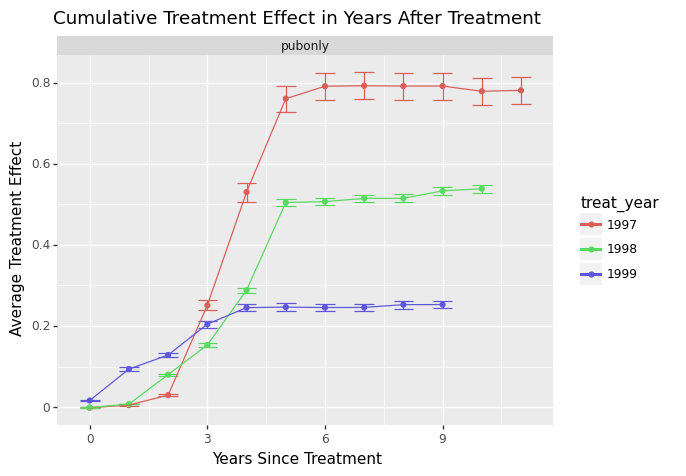

<ggplot: (135585473006)>

In [39]:
# Plotnine code to make plot for post-treatment effects
all_years['adjusted_year'] = all_years["year"] - all_years["treat_year"]
post_treat = all_years[(all_years["adjusted_year"] >= 0) & (all_years["treat_year"] != 2008)].copy()

post_treat['att-error'] =post_treat['att'] - post_treat['std']
post_treat['att+error'] = post_treat['att'] + post_treat['std']
post_treat['treat_year'] = post_treat['treat_year'].apply(lambda x: str(x))

ggplot(post_treat, aes(x='adjusted_year', y='att', color = 'treat_year', group='treat_year')) + \
geom_errorbar(aes(ymin = 'att-error', ymax = 'att+error')) + \
geom_point() + \
geom_line() + \
facet_wrap('response') + \
xlab('Years Since Treatment') + \
ylab('Average Treatment Effect') + \
labs(title = "Cumulative Treatment Effect in Years After Treatment")

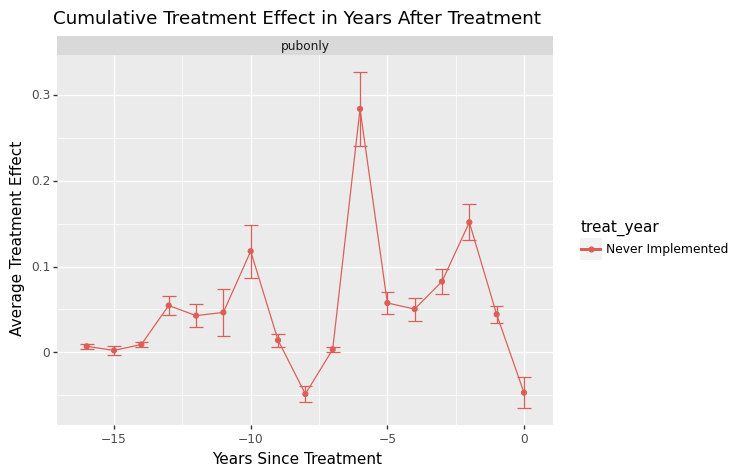

<ggplot: (95044841909)>

In [8]:
# Plotnine code to show treatment effects for states never treated

never_treat = all_years[all_years["treat_year"] == 2008].copy()

never_treat['att-error'] = never_treat['att'] - never_treat['std']
never_treat['att+error'] = never_treat['att'] + never_treat['std']

# So that plotnine treats
never_treat["treat_year"] = never_treat["treat_year"].replace(2008, "Never Implemented")

ggplot(never_treat, aes(x='adjusted_year', y='att', color = 'treat_year', group='treat_year')) + \
geom_errorbar(aes(ymin = 'att-error', ymax = 'att+error')) + \
geom_point() + \
geom_line() + \
facet_wrap('response') + \
xlab('Years Since Treatment') + \
ylab('Average Treatment Effect') + \
labs(title = "Cumulative Treatment Effect in Years After Treatment")